In [1]:
import pyvisa as pv
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio   
import pickle
import scipy.signal
from tqdm.notebook import tqdm, trange
from scipy.special import erfc
import scipy as sp
from optic.comm.modulation import modulateGray, demodulateGray, GrayMapping
from optic.dsp.core import firFilter, pulseShape, lowPassFIR, pnorm, upsample
from optic.comm.metrics import signal_power,fastBERcalc
from optic.dsp.equalization import *
from optic.plot import eyediagram
plt.rcParams["figure.figsize"] = (12,6)

from funcoesLab import *

c:\Users\lucas\anaconda3\envs\Opticompy\lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# #Conectar dispositivos
rm = pv.ResourceManager()
print(rm.list_resources())

DAC = rm.open_resource('USB0::0x0957::0x5707::MY53802202::0::INSTR')
print('info DAC:', DAC.query('*IDN?'))

DAC.write('*rst')
DAC.write('*opc?') 

scope = rm.open_resource('USB0::0x2A8D::0x1768::MY55440748::0::INSTR')
print('Info Osciloscopio:', scope.query('*IDN?'))
scope.write('*rst')
scope.write('*opc?') 

np.set_printoptions(threshold=np.inf)
del DAC.timeout

print('')

('USB0::0x0957::0x5707::MY53802202::0::INSTR', 'USB0::0x2A8D::0x1768::MY55440748::0::INSTR')
info DAC: Agilent Technologies,33622A,MY53802202,A.01.11-2.25-03-64-02

Info Osciloscopio: KEYSIGHT TECHNOLOGIES,DSO-X 3014T,MY55440748,04.06.2015051201




In [341]:
#Encerrar a conexão com os dispositivos
DAC.close()
scope.close()
rm.close()


In [12]:
# DAC.write('*rst')
# DAC.write('*opc?')

# scope.write('*rst')
# scope.write('*opc?') 

#Valores Geração do sinal
M = 4 # order of the modulation format
nsimbolos = 1e4
SPS = 4
formatoPulso = 'nrz' #'rect','nrz','rrc'
nTaps = 1024
alpha = 0.01

bits,simbolos = Gerar_Simbolos(M,nsimbolos,SPS,formatoPulso,nTaps,alpha)

#Gerando uma onda arbitraria no DAC
Porta = 2
fs = 250e6
V_High = 4
V_Low = 0
pontos = simbolos
filtro = 'NORMal'
DAC.write(f'SOURce{Porta}:DATA:VOL:CLE')
Onda_Dac_Keysight(DAC,Porta,fs*SPS,V_High,V_Low,pontos,'teste',filtro)

DAC.query('*OPC?')   

#Configurar O osciloscopio
tempo = nsimbolos/(fs)
canais = np.array([3])
vDivisao = np.array([0.8])
impedancia = np.array(['FIFTy'])
trigger = np.array([0])
offset = np.array([2])
ConfigurarScope(scope,tempo,canais,vDivisao,impedancia,canais[0],trigger,offset)
# #Plotar o sinal
scope.write('waveform:format byte')
scope.write(':WAVeform:POINts:MODE MAX')
#scope.write(':WAVeform:POINts: 20000')
scope.write('digitize')
scope.query('*OPC?')   




+0,"No error"



'11\n'

Numero de pontos do osciloscopio: 200000
Amostras por simbolo do osciloscopio: 20.0
Janela de tempo do Osciloscopio: 0.04 ms
Frequencia de amostragem do osciloscopio: 5000.0 MHz


Text(0.5, 1.0, 'Sinais depois da sicronização')

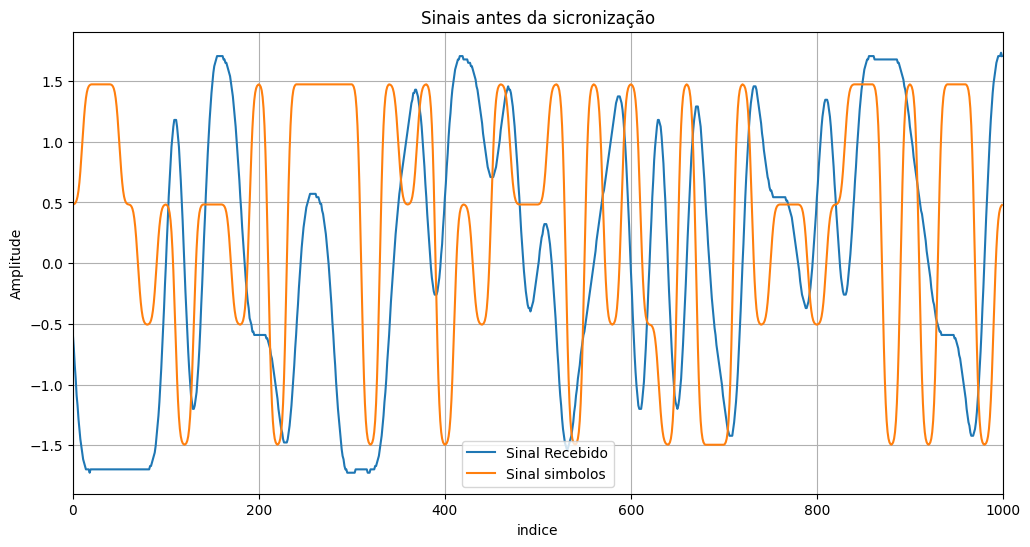

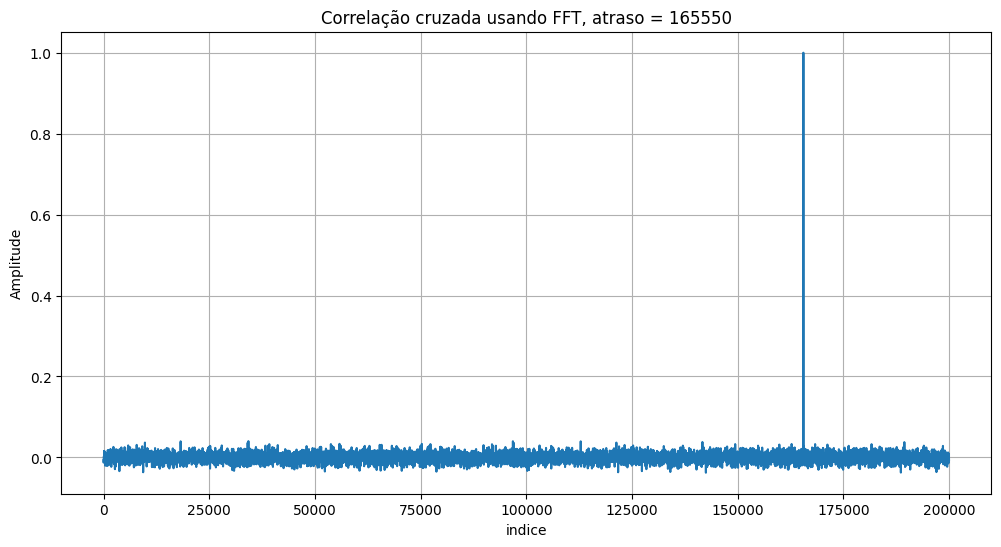

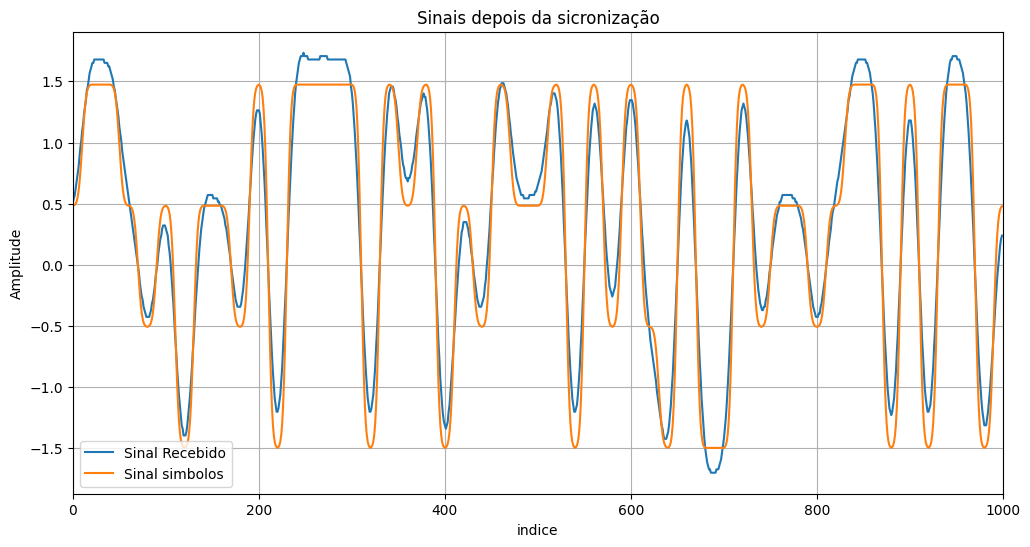

In [10]:
t,y = AdquirirOnda(scope,3)

print(f'Numero de pontos do osciloscopio: {len(y)}')
print(f'Amostras por simbolo do osciloscopio: {len(y)/(nsimbolos)}')
print(f'Janela de tempo do Osciloscopio: {round((t[-1]-t[0])*1e3,3)} ms')
print(f'Frequencia de amostragem do osciloscopio: {round(1e-6/(t[1]-t[0]),3)} MHz')

bits,simbolos = Gerar_Simbolos(M,nsimbolos,int(len(y)/(nsimbolos)),formatoPulso,nTaps,alpha,bits)
plt.figure(1)
plt.plot(pnorm(y-np.mean(y))[0:1000],label='Sinal Recebido')
plt.plot(pnorm(simbolos-np.mean(simbolos))[0:1000],label='Sinal simbolos')
plt.xlim(0,1000)
plt.xlabel('indice')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()
plt.title('Sinais antes da sicronização')

plt.figure(2)
corr = periodic_corr(pnorm(simbolos-np.mean(simbolos)), pnorm(y-np.mean(y)))
delay = np.argmax(corr)
plt.plot(corr/np.max(corr))
plt.xlabel('indice')
plt.ylabel('Amplitude')
plt.grid()
plt.title(f'Correlação cruzada usando FFT, atraso = {int(delay)}')

plt.figure(3)
ysicronizado = np.roll(y,delay)
plt.plot(pnorm(ysicronizado-np.mean(ysicronizado))[0:1000],label='Sinal Recebido')
plt.plot(pnorm(simbolos-np.mean(simbolos))[0:1000],label='Sinal simbolos')
plt.xlim(0,1000)
plt.xlabel('indice')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()
plt.title('Sinais depois da sicronização')



In [8]:
len(y)//5

8000

Numero de pontos do osciloscopio: 200000
Amostras por simbolo do osciloscopio: 20.0
Janela de tempo do Osciloscopio: 0.04 ms
Frequencia de amostragem do osciloscopio: 5000.0 MHz
200000
40000


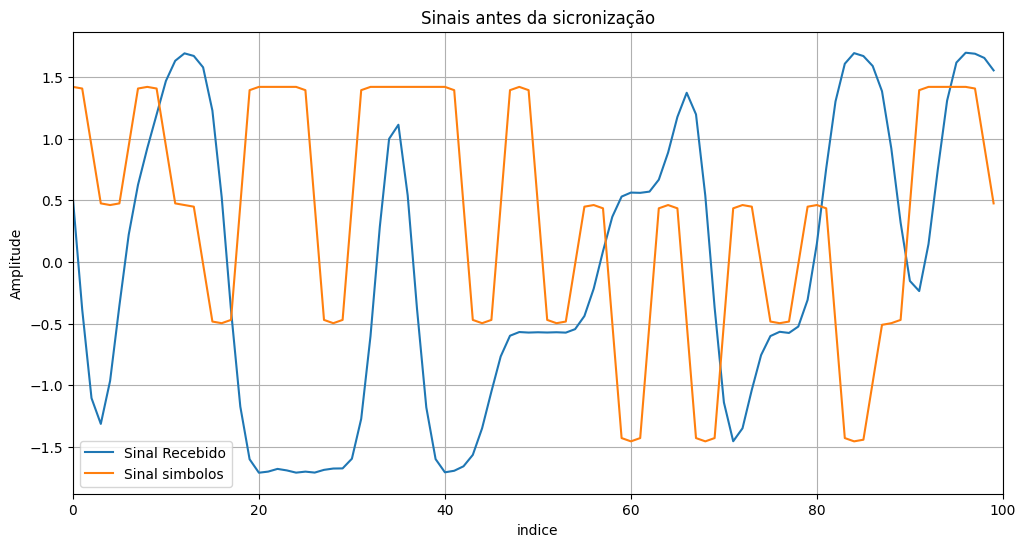

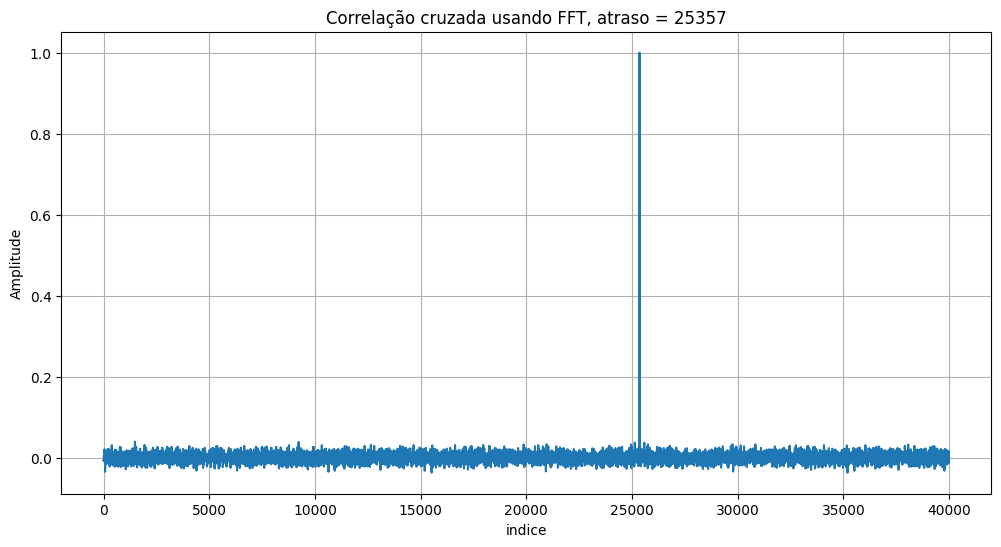

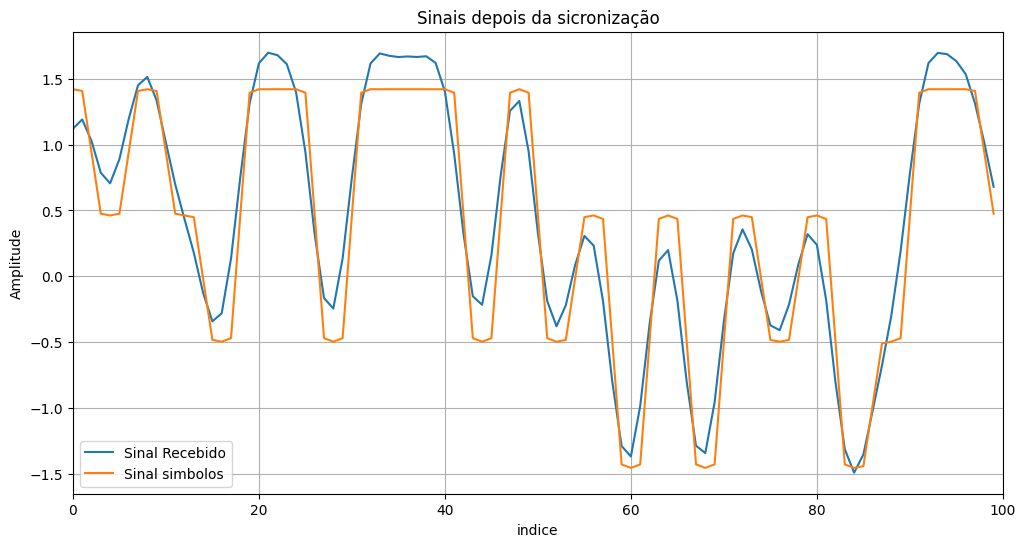

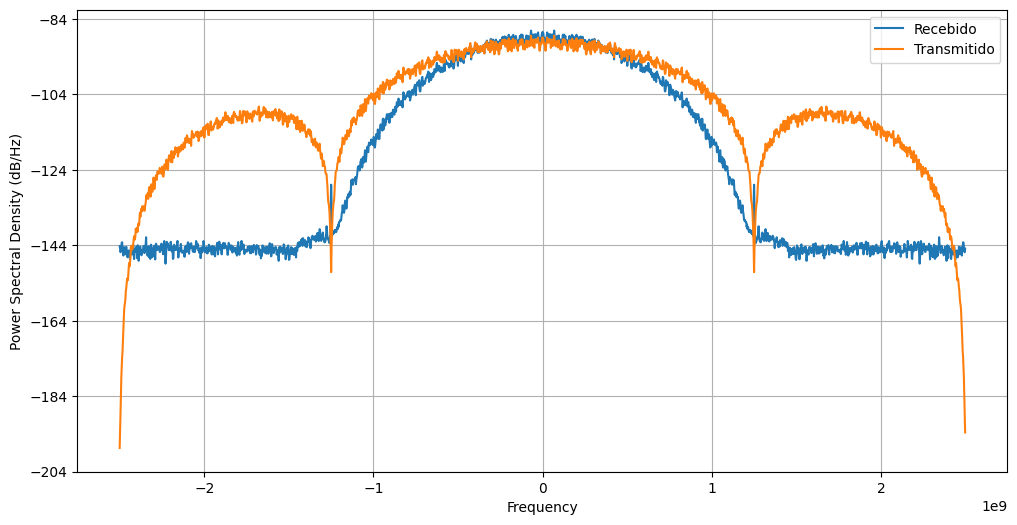

In [22]:
t,y = AdquirirOnda(scope,3)

print(f'Numero de pontos do osciloscopio: {len(y)}')
print(f'Amostras por simbolo do osciloscopio: {len(y)/(nsimbolos)}')
print(f'Janela de tempo do Osciloscopio: {round((t[-1]-t[0])*1e3,3)} ms')
print(f'Frequencia de amostragem do osciloscopio: {round(1e-6/(t[1]-t[0]),3)} MHz')

#bits,simbolos = Gerar_Simbolos(M,nsimbolos,int(len(y)/(nsimbolos)),formatoPulso,nTaps,alpha,bits)
print(len(y))
y = sp.signal.resample(y,len(y)//5)
print(len(y))
plt.figure(1)
plt.plot(pnorm(y-np.mean(y))[0:100],label='Sinal Recebido')
plt.plot(pnorm(simbolos-np.mean(simbolos))[0:100],label='Sinal simbolos')
plt.xlim(0,100)
plt.xlabel('indice')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()
plt.title('Sinais antes da sicronização')

plt.figure(2)
corr = periodic_corr(pnorm(simbolos-np.mean(simbolos)), pnorm(y-np.mean(y)))
delay = np.argmax(corr)
plt.plot(corr/np.max(corr))
plt.xlabel('indice')
plt.ylabel('Amplitude')
plt.grid()
plt.title(f'Correlação cruzada usando FFT, atraso = {int(delay)}')

plt.figure(3)
ysicronizado = np.roll(y,delay)
plt.plot(pnorm(ysicronizado-np.mean(ysicronizado))[0:100],label='Sinal Recebido')
plt.plot(pnorm(simbolos-np.mean(simbolos))[0:100],label='Sinal simbolos')
plt.xlim(0,100)
plt.xlabel('indice')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()
plt.title('Sinais depois da sicronização')

plt.figure(4)
plt.psd(pnorm(ysicronizado-np.mean(ysicronizado)),Fs=1/(t[1]-t[0]), NFFT = 2*1024, sides='twosided', label = 'Recebido')
plt.psd(pnorm(simbolos-np.mean(simbolos)),Fs=1/(t[1]-t[0]), NFFT = 2*1024, sides='twosided', label = 'Transmitido')

#plt.xlim(-2*fs,2*fs)
#plt.ylim(-150,-73)
plt.legend()

In [106]:
np.savez('250Mbould-4SpS', simbolos=simbolos,t=t, y=y,ysicronizado=ysicronizado)

In [105]:
from optic.utils import parameters
teste = parameters()
teste.numIter =5
teste.SpS =int(len(y)/(nsimbolos))
teste.storeCoeff = False
teste.constType = 'pam'
teste.nTaps = 16
teste.alg ='lms'
#teste.returnResults = True
teste.L = [int(0.2*len(simbolos)),int(0.2*len(simbolos))]
yEq = mimoAdaptEqualizer(ysicronizado,teste,dx=simbolos)

plt.plot(pnorm(yEq-np.mean(yEq))[0:1000],label='Sinal Recebido')
#plt.plot(pnorm(simbolos-np.mean(simbolos))[0:1000],label='Sinal simbolos')
#plt.xlim(0,1000)
plt.xlabel('indice')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()
plt.title('Sinais depois da sicronização')
print(teste.view())
(errSq[0][0:10])

  0%|          | 0/5 [00:00<?, ?it/s]

TypeError: not enough arguments: expected 11, got 10

In [86]:
# Demodulação

# simbolosT = (pnorm(4*(simbolos-np.min(simbolos))/np.max(2*simbolos)))[0::SPS]
# simbolosR =(pnorm(np.roll(yd,delay)))[0::SPS]
# simbolosR = simbolosR[0:len(simbolosT)]
# bitsT  = demodulateGray((simbolosT)-np.mean(simbolosT), M, 'pam')
# bitsR  = demodulateGray((simbolosR)-np.mean(simbolosR), M, 'pam')
# erros = bitsT ^ bitsR
# erros = len(erros[erros!=0])
# ber = erros/len(bitsT)
# plt.figure(4)
# plt.plot(np.roll((bitsT ^ bitsR),int(-delay//SPS*np.log2(M))))
# plt.xlabel('indice')
# plt.ylabel('Resultado')
# plt.grid()
# plt.title(f'Mapa de erros da transmissão')
# print('Resultados')
# print(f'Numero de erros: {erros}')
# print(f'ber: {ber}')

# teste de largura de banda

In [107]:
def Onda_Dac_Keysight(DAC,Porta,fs,V_High,V_Low,pontos,Nome_Onda):
    DAC.write(f'SOURce{Porta}:DATA:VOL:CLE')
    DAC.write('FORMat:BORDer SWAPped')
    DAC.write_binary_values('SOURCE{}:DATA:ARB:DAC {},'.format(Porta,Nome_Onda),pontos,datatype='h')
    DAC.query('*OPC?')  
    print(DAC.query('SYSTEM:ERROR?'))
    DAC.write('SOURCE{}:FUNC ARB'.format(Porta))
    DAC.write('SOURCE{}:FUNC:ARB {}'.format(Porta,Nome_Onda)) 
    DAC.write('SOURCE{}:FUNC:ARB:SRAT {}'.format(Porta,fs))
    DAC.write(f'SOURCE2:VOLT {(V_High-V_Low)}')
    DAC.write(f'SOURCE2:VOLT:OFFS {(V_High+V_Low)/2}')
    DAC.write('OUTP{} ON'.format(Porta))
    DAC.write('DISPLAY:FOCUS CH{}'.format(Porta))
      


# DAC.write('*rst')

# DAC.write('*opc?')

# scope.write('*rst')
# scope.write('*opc?') 
#Valores Geração do sinal
M = 4 # order of the modulation format
npontos = 1e5
σ2  = 0.00050  # variância
μ   = 0      # média
ruido  = np.random.normal(μ,np.sqrt(σ2), int(npontos))
ruido = ruido/np.max(np.abs(ruido))
ruido = ruido*32766

ruido = (np.rint(ruido)).astype(int)
print(np.max(ruido))
#Gerando uma onda arbitraria no DAC
DAC = DAC
Porta = 2
fs = 1e9
V_High = 1
V_Low = -1
pontos = ruido
filtro = 'NORMAL'
DAC.write('*CLS')
#DAC.write('SOURce2:DATA:VOL:CLE')
print(DAC.query('SYSTEM:ERROR?'))  
Onda_Dac_Keysight(DAC,Porta,fs,V_High,V_Low,pontos,filtro)

32766
+0,"No error"

+0,"No error"



In [153]:
scope.write(':SINGle')

scope.write(":WAVeform:POINts:MODE MAX")

scope.write(':WAVeform:POINts 10000000')
t4,y4 = AdquirirOnda(scope,3)
t = t4
y = y4
print(f'Numero de pontos do osciloscopio: {len(y)}')
print(f'Amostras por simbolo do osciloscopio: {len(y)/(nsimbolos)}')
print(f'Janela de tempo do Osciloscopio: {round((t[-1]-t[0])*1e3,3)} ms')
print(f'Frequencia de amostragem do osciloscopio: {round(1e-6/(t[1]-t[0]),3)} MHz')


Numero de pontos do osciloscopio: 2000000
Amostras por simbolo do osciloscopio: 2.0
Janela de tempo do Osciloscopio: 2.0 ms
Frequencia de amostragem do osciloscopio: 1000.0 MHz


In [182]:
scope.write(':SINGle')

scope.write(":WAVeform:POINts:MODE MAX")

scope.write(':WAVeform:POINts 10000000')
t2,y2 = AdquirirOnda(scope,3)



Numero de pontos do osciloscopio: 2500001
Amostras por simbolo do osciloscopio: 2.500001
Janela de tempo do Osciloscopio: 2.0 ms
Frequencia de amostragem do osciloscopio: 1250.0 MHz


Text(0, 0.5, 'Densidade Espectral de Potência (dB/Hz)')

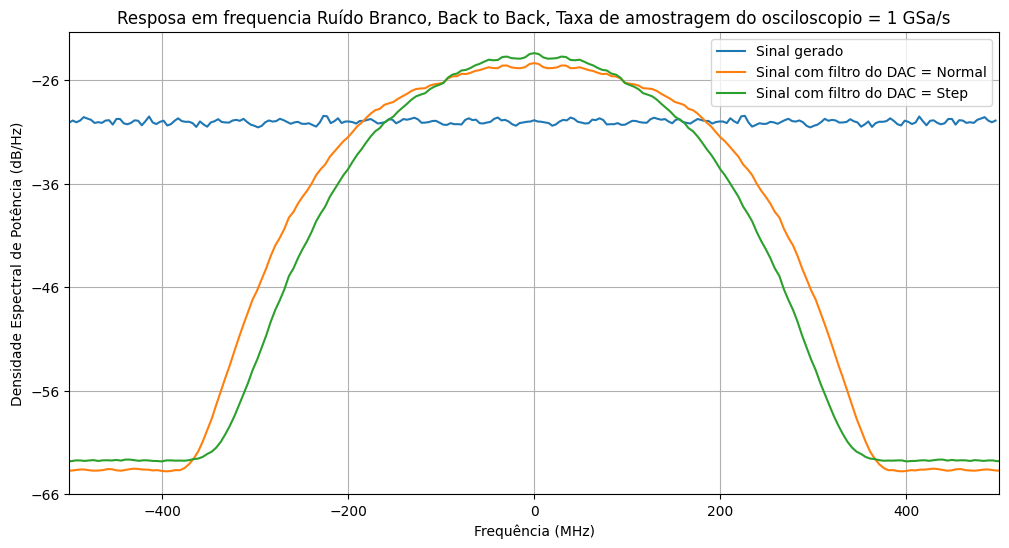

In [177]:
scope.write(':SINGle')

scope.write(":WAVeform:POINts:MODE MAX")

scope.write(':WAVeform:POINts 10000000')
t,y = AdquirirOnda(scope,3)


print(f'Numero de pontos do osciloscopio: {len(y)}')
print(f'Amostras por simbolo do osciloscopio: {len(y)/(nsimbolos)}')
print(f'Janela de tempo do Osciloscopio: {round((t[-1]-t[0])*1e3,3)} ms')
print(f'Frequencia de amostragem do osciloscopio: {round(1e-6/(t[1]-t[0]),3)} MHz')

plt.psd(pnorm(ruido),Fs=1000,sides='twosided')
plt.psd(pnorm(ynormal-np.mean(ynormal)),Fs=1e-6/(t[1]-t[0]),sides='twosided')
plt.psd(pnorm(ystep-np.mean(ystep)),Fs=1e-6/(t[1]-t[0]),sides='twosided')
plt.xlim(-500,500)
#plt.axhline(-22.5,linestyle='--',color='k')
#plt.axhline(-26.5,linestyle='--',color='k')
plt.title('Resposa em frequencia Ruído Branco, Back to Back, Taxa de amostragem do osciloscopio = 1 GSa/s')
plt.legend(['Sinal gerado','Sinal com filtro do DAC = Normal','Sinal com filtro do DAC = Step'])
plt.xlabel('Frequência (MHz)')
plt.ylabel('Densidade Espectral de Potência (dB/Hz)')

In [ ]:
np.savez('250Mbould-4SpS', simbolos=simbolos,t=t, y=y,)

Text(0, 0.5, 'Densidade Espectral de Potência (dB/Hz)')

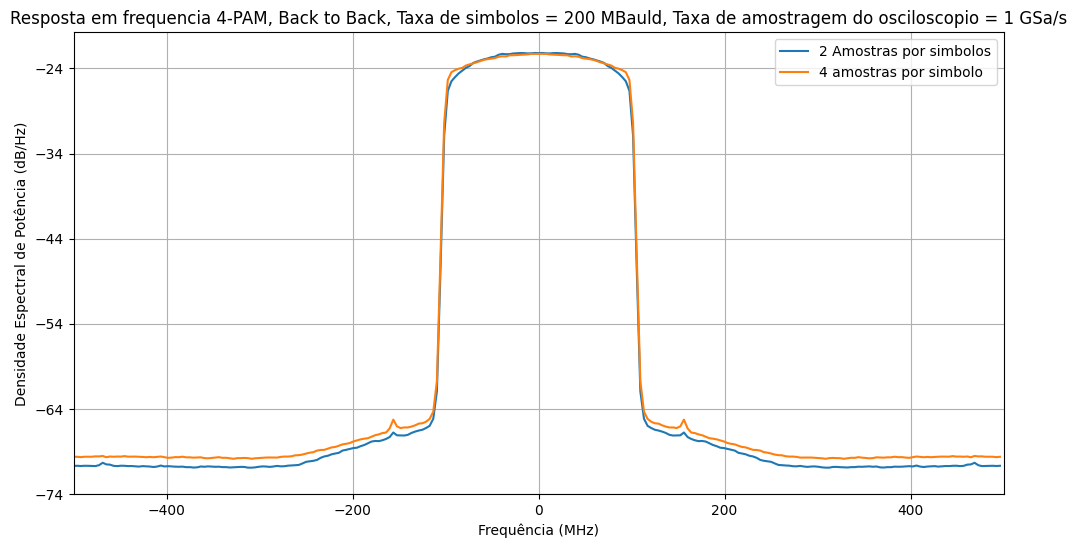

In [156]:
#NRZ, α=0.01
plt.psd(pnorm(y2-np.mean(y2)),Fs=1e-6/(t2[1]-t2[0]),sides='twosided')
plt.psd(pnorm(y4-np.mean(y4)),Fs=1e-6/(t4[1]-t4[0]),sides='twosided')
plt.xlim(-500,500)
#plt.axhline(-22.5,linestyle='--',color='k')
#plt.axhline(-26.5,linestyle='--',color='k')
plt.title('Resposta em frequencia 4-PAM, RRC α=0.01, Back to Back, Taxa de simbolos = 200 MBauld')
plt.legend(['2 Amostras por simbolos','4 amostras por simbolo'])
plt.xlabel('Frequência (MHz)')
plt.ylabel('Densidade Espectral de Potência (dB/Hz)')
plt.figure(2)

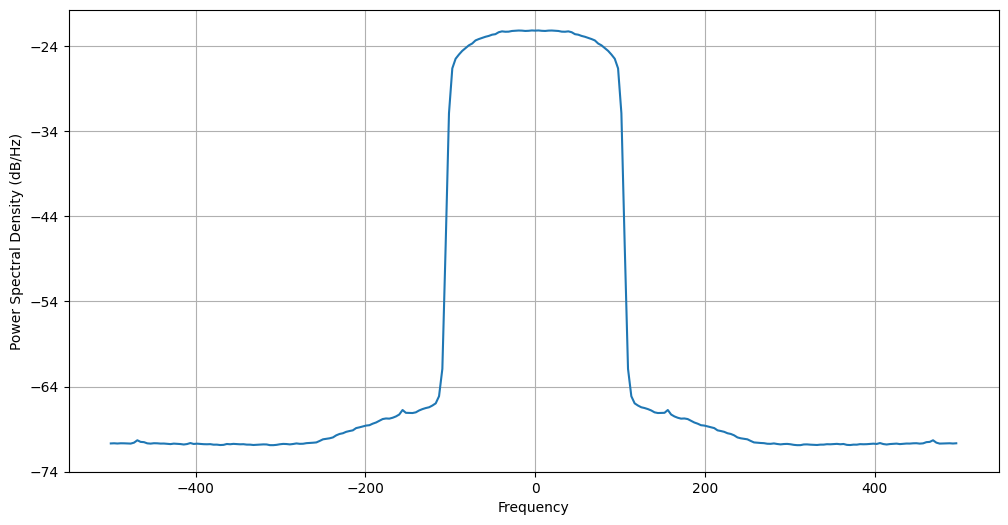

In [163]:
x,p,l = plt.psd(pnorm(y2-np.mean(y2)),Fs=1e-6/(t2[1]-t2[0]),sides='twosided')

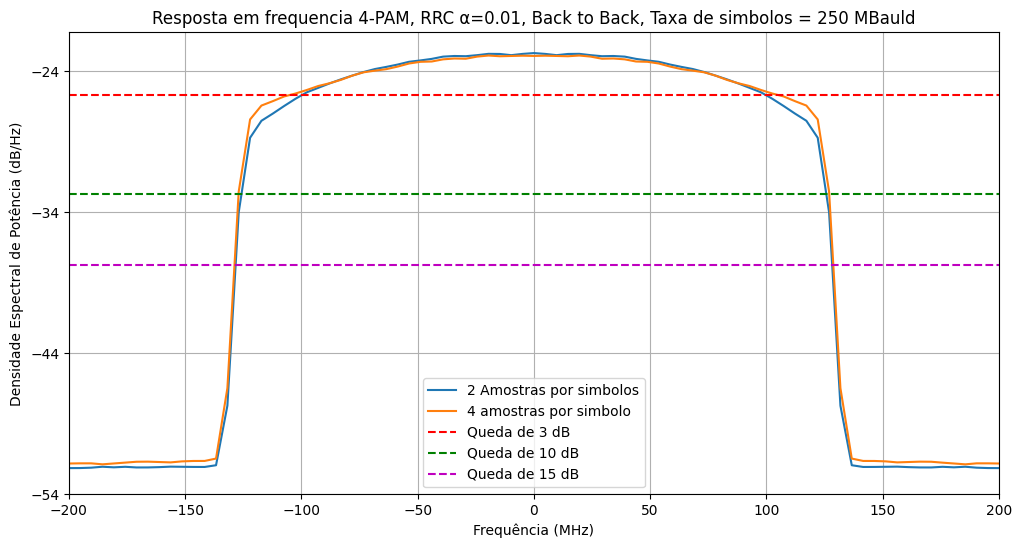

In [183]:
p,f = plt.psd(pnorm(y2-np.mean(y2)),Fs=1e-6/(t2[1]-t2[0]),sides='twosided')
plt.psd(pnorm(y4-np.mean(y4)),Fs=1e-6/(t4[1]-t4[0]),sides='twosided')
plt.xlim(-200,200)
#plt.axhline(-22.5,linestyle='--',color='k')
#plt.axhline(-26.5,linestyle='--',color='k')
plt.title('Resposta em frequencia 4-PAM, RRC α=0.01, Back to Back, Taxa de simbolos = 250 MBauld')
plt.xlabel('Frequência (MHz)')
plt.ylabel('Densidade Espectral de Potência (dB/Hz)')
plt.axhline(np.max(10*np.log10(p))-3,linestyle='--',color='r',)
plt.axhline(np.max(10*np.log10(p)) -10,linestyle='--',color='g')
plt.axhline(np.max(10*np.log10(p)) -15,linestyle='--',color='m')
plt.legend(['2 Amostras por simbolos','4 amostras por simbolo', 'Queda de 3 dB', 'Queda de 10 dB', 'Queda de 15 dB'])


In [173]:
np.max(10*np.log10(p))

-22.18861460167068